In [ ]:
!gdown 1N193DSAgGZgcKuT1LDY9iszV0DV74uC2

Downloading...
From: https://drive.google.com/uc?id=1N193DSAgGZgcKuT1LDY9iszV0DV74uC2
To: /content/FruitinAmazon.zip
100% 1.24M/1.24M [00:00<00:00, 14.7MB/s]


In [ ]:
!unzip /content/FruitinAmazon.zip

Archive:  /content/FruitinAmazon.zip
  inflating: FruitinAmazon/test/cupuacu/download (5).jpeg  
  inflating: FruitinAmazon/test/acai/images (2).jpeg  
  inflating: FruitinAmazon/test/cupuacu/download (3).jpeg  
  inflating: FruitinAmazon/test/acai/images (16).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (2).jpeg  
  inflating: FruitinAmazon/train/pupunha/images (1).jpeg  
  inflating: FruitinAmazon/test/cupuacu/download (2).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (1).jpeg  
  inflating: FruitinAmazon/train/acai/images (3).jpeg  
  inflating: FruitinAmazon/train/acai/images (4).jpeg  
  inflating: FruitinAmazon/test/graviola/download (1).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (11).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (4).jpeg  
  inflating: FruitinAmazon/train/acai/images (11).jpeg  
  inflating: FruitinAmazon/test/tucuma/download (1).jpeg  
  inflating: FruitinAmazon/test/acai/images.jpeg  
  inflating: FruitinAmazon/train

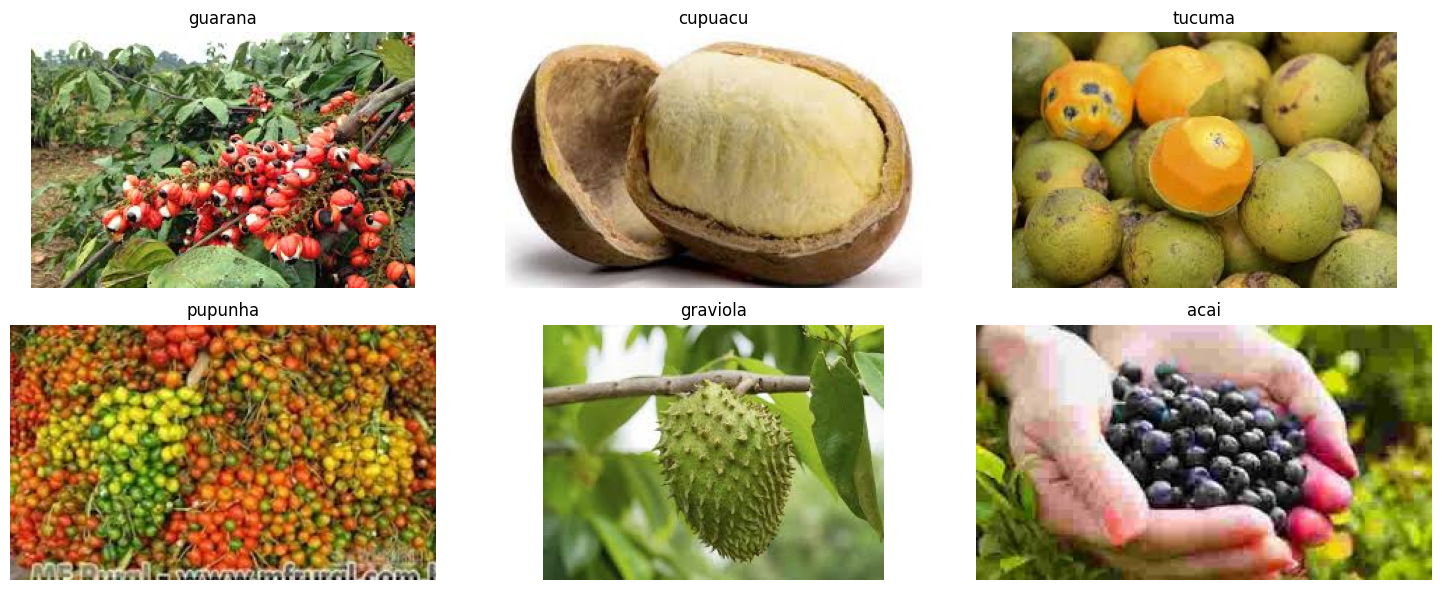

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from PIL import Image

train_dir = "/content/FruitinAmazon/train"
test_dir = "/content/FruitinAmazon/test"

img_height, img_width = 28, 28

def load_and_visualize_images(train_dir, num_rows=2):
  class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

  selected_images = []
  labels = []
  for class_dir in class_dirs:
    class_path = os.path.join(train_dir, class_dir)
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('png', 'jpg', 'jpeg'))]
    if images:
      selected_image = random.choice(images)
      selected_images.append(os.path.join(class_path, selected_image))
      labels.append(class_dir)

  num_cols = (len(selected_images) + num_rows - 1) // num_rows

  fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))
  axes = axes.flatten()

  for i, img_path in enumerate(selected_images):
    img = mpimg.imread(img_path)
    axes[i].imshow(img)
    axes[i].set_title(labels[i])
    axes[i].axis('off')

  for j in range(i + 1, len(axes)):
    axes[j].axis('off')

  plt.tight_layout()
  plt.show()

load_and_visualize_images(train_dir)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

batch_size = 32
validation_split = 0.2
seed = 123

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

class_names = train_ds.class_names

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(normalization_layer(x)), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
num_classes = len(class_names)

model = models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding="same", input_shape=(128, 128, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),

    tf.keras.layers.Conv2D(64, (3, 3), padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),

    tf.keras.layers.Conv2D(128, (3, 3), padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Dense(num_classes, activation="softmax")
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('mymodel.h5', save_best_only=True, monitor='val_loss')
earlyStoping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint_cb, earlyStoping_cb]
)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2888 - loss: 2.1243

3/3 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.2964 - loss: 2.1241 - val_accuracy: 0.1667 - val_loss: 1.8224
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7040 - loss: 0.8252 - val_accuracy: 0.1111 - val_loss: 2.0040
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7687 - loss: 0.5770 - val_accuracy: 0.1111 - val_loss: 1.9472
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8798 - loss: 0.4104 - val_accuracy: 0.1667 - val_loss: 2.0093
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9093 - loss: 0.4200 - val_accuracy: 0.1667 - val_loss: 2.1984
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8129 - loss: 0.4509 - val_accuracy: 0.1111 - val_loss: 2.4344


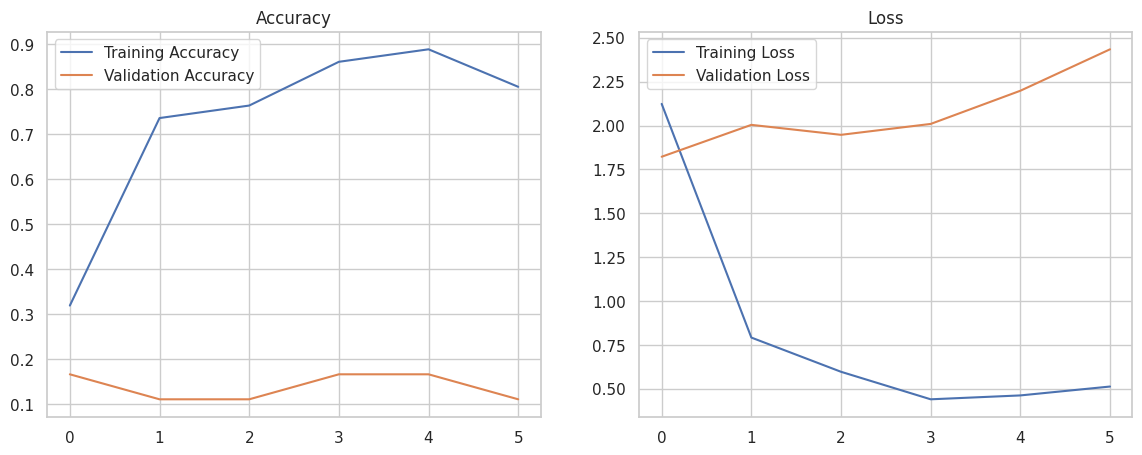

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.1445 - loss: 2.6832 - val_accuracy: 0.2778 - val_loss: 2.0894
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.2127 - loss: 2.0558 - val_accuracy: 0.2222 - val_loss: 1.9856
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2552 - loss: 1.8306 - val_accuracy: 0.0000e+00 - val_loss: 2.0489
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 943ms/step - accuracy: 0.3012 - loss: 1.7422 - val_accuracy: 0.0556 - val_loss: 2.0812
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 961ms/step - accuracy: 0.2344 - loss: 1.7678 - val_accuracy: 0.0556 - val_loss: 2.0492
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2747 - loss: 1.6600 - val_accuracy: 0.0556 - val_loss: 1.9822
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 962ms/step - accuracy: 0.5707 - loss: 1.3837 - val_accuracy: 0.1111 - val_loss: 1.9110
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 954ms/step - accuracy: 0.4076 - loss: 1.5012 - val_accuracy: 0.1667 - val_loss: 1.8584

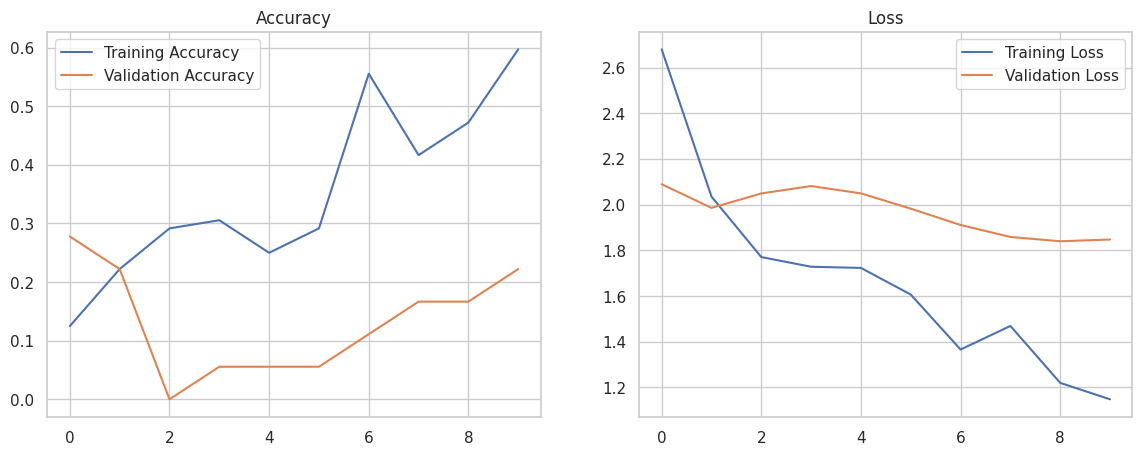

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Classification Report:
              precision    recall  f1-score   support

        acai       0.00      0.00      0.00         1
     cupuacu       0.50      0.50      0.50         2
    graviola       0.25      0.33      0.29         3
     guarana       0.33      0.40      0.36         5
     pupunha       0.00      0.00      0.00         4
      tucuma       0.00      0.00      0.00         3

    accuracy                           0.22        18
   macro avg       0.18      0.21      0.19        18
weighted avg       0.19      0.22      0.20        18



In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

# Set up image dimensions - MobileNetV2 expects 224x224 images
img_height, img_width = 224, 224
batch_size = 32

# Data preparation with validation split
validation_split = 0.2
seed = 123

num_classes = len(class_names)

# AUTOTUNE for better performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create base model with pre-trained weights
base_model = MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False

# Create a new model on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

# Train the model
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation accuracy: {val_accuracy:.4f}")

# Plot the training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Generate predictions for the validation dataset
predictions = []
labels = []

for x, y in val_ds:
    pred = model.predict(x)
    pred_classes = np.argmax(pred, axis=1)
    true_classes = np.argmax(y.numpy(), axis=1)

    predictions.extend(pred_classes)
    labels.extend(true_classes)

# Generate classification report
print("Classification Report:")
report = classification_report(labels, predictions, target_names=class_names)
print(report)

# Save the model
model.save('transfer_learning_fruits_model.h5')